In [3]:
import os
import json
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from datetime import datetime

# 1. 데이터셋 load

In [6]:
# 파일 경로 설정
train_path = '/Volumes/Expansion/google_analytics_customer/train.csv'
test_path = '/Volumes/Expansion/google_analytics_customer/test.csv'

# 데이터 로딩 함수 정의
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'})

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {csv_path.split('/')[-1]}. Shape: {df.shape}")
    return df

# 데이터 로딩
train_df = load_df(train_path)
test_df = load_df(test_path)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [7]:
# 타겟 설정
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0).astype(float)
y = np.log1p(train_df['totals.transactionRevenue'])

del train_df['totals.transactionRevenue']

# 2. 데이터 전처리
## 1) 컬럼 제거

### (1) Constant value를 갖는 컬럼 제거 + 결측치 처리
- 모든 행이 같은 값을 가지고 있는 컬럼 조회

In [8]:
# 고정값 컬럼 제거
const_cols = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(columns=const_cols, inplace=True)
test_df.drop(columns=[col for col in const_cols if col in test_df.columns], inplace=True)

# 일부 컬럼 NaN 처리
na_fill_dict = {
    'totals.bounces': '0',
    'totals.newVisits': '0',
    'trafficSource.adwordsClickInfo.isVideoAd': True,
    'trafficSource.isTrueDirect': False
}

for col, fill_val in na_fill_dict.items():
    train_df[col] = train_df[col].fillna(fill_val)
    test_df[col] = test_df[col].fillna(fill_val)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_33535/347034232.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[col] = train_df[col].fillna(fill_val)
/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_33535/347034232.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[col] = test_df[col].fillna(fill_val)


In [9]:
# 공통 컬럼만 남기기
common_cols = [col for col in train_df.columns if col in test_df.columns and train_df[col].nunique() > 1]
train_df = train_df[common_cols]
test_df = test_df[common_cols]

### (2) feature engineering

In [10]:
# 데이터 병합 후 피처 엔지니어링
trn_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df])

merged_df['diff_visitId_time'] = merged_df['visitId'] - merged_df['visitStartTime']
merged_df['diff_visitId_time'] = (merged_df['diff_visitId_time'] != 0).astype(int)
del merged_df['visitId']

if 'sessionId' in merged_df.columns:
    del merged_df['sessionId']

merged_df['formated_date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
merged_df['month'] = merged_df['formated_date'].dt.month
merged_df['quarter_month'] = merged_df['formated_date'].dt.day // 8
merged_df['day'] = merged_df['formated_date'].dt.day
merged_df['weekday'] = merged_df['formated_date'].dt.weekday

# 일별 평균 hits
merged_df['totals.hits'] = merged_df['totals.hits'].astype(int)
merged_df['mean_hits_per_day'] = merged_df.groupby(['day'])['totals.hits'].transform('mean')
del merged_df['day']

# 방문 시간 시각화
merged_df['formated_visitStartTime'] = pd.to_datetime(
    merged_df['visitStartTime'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))))
merged_df['visit_hour'] = merged_df['formated_visitStartTime'].dt.hour

# 불필요한 컬럼 제거
del merged_df['date']
del merged_df['formated_date']
del merged_df['visitStartTime']
del merged_df['formated_visitStartTime']

In [18]:
merged_df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent',
       'diff_visitId_time', 'month', 'quarter_month', 'weekday',
       'mean_hits_per_day', 'visit_hour'],
      dtype='object')

### (3) label encoding

In [11]:
# 레이블 인코딩
for col in merged_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour']:
        continue
    if merged_df[col].dtype == object or merged_df[col].dtype == bool:
        merged_df[col], _ = pd.factorize(merged_df[col])

# 범주형/수치형 분리
numerics = [col for col in merged_df.columns if 'totals.' in col]
numerics += ['visitNumber', 'mean_hits_per_day', 'fullVisitorId']
categorical_feats = [col for col in merged_df.columns if col not in numerics]

for col in categorical_feats:
    merged_df[col] = merged_df[col].astype(int)

### (4) train/valid/test 분리

In [12]:
# train/test 분리
train_df = merged_df[:trn_len]
test_df = merged_df[trn_len:]

train_X = train_df.drop(['fullVisitorId'], axis=1)
test_X = test_df.drop(['fullVisitorId'], axis=1)

# 훈련/검증 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_X, y, test_size=0.2, random_state=42)

# 3. 모델 훈련

### (1) LightGBM 훈련

In [13]:
# 모델 훈련 함수
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 30,
        "min_child_samples": 100,
        "learning_rate": 0.1,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.5,
        "bagging_frequency": 5,
        "bagging_seed": 2018,
        "verbosity": -1
    }

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)

    model = lgb.train(params, lgtrain, 1000,
                      valid_sets=[lgval],
                      callbacks=[early_stopping(100), lgb.log_evaluation(100)])

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# 모델 훈련 및 예측
pred_test, model, pred_val = run_lgb(X_train, y_train, X_valid, y_valid, test_X)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.62651
[200]	valid_0's rmse: 1.62082
[300]	valid_0's rmse: 1.61959
Early stopping, best iteration is:
[287]	valid_0's rmse: 1.61908


### (2) Metrics 확인

In [14]:
# 음수 예측 제거
pred_val[pred_val < 0] = 0

# 원본 merged_df에서 검증 인덱스에 해당하는 fullVisitorId, 원래 revenue값 복원
val_pred_df = pd.DataFrame()
val_pred_df["fullVisitorId"] = train_df.iloc[X_valid.index]["fullVisitorId"].values
val_pred_df["transactionRevenue"] = np.expm1(y_valid)  # 로그를 다시 원복
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)   # 예측값도 원복

# 사용자 단위로 집계
val_pred_df = val_pred_df.groupby("fullVisitorId")[["transactionRevenue", "PredictedRevenue"]].sum().reset_index()

# RMSLE 계산 (로그 변환 후)
rmsle = np.sqrt(metrics.mean_squared_error(
    np.log1p(val_pred_df["transactionRevenue"].values),
    np.log1p(val_pred_df["PredictedRevenue"].values)
))

# 로그 예측값 복원
val_pred_df['log_true'] = np.log1p(val_pred_df['transactionRevenue'])
val_pred_df['log_pred'] = np.log1p(val_pred_df['PredictedRevenue'])
val_pred_df['error'] = val_pred_df['log_true'] - val_pred_df['log_pred']

# 평가지표 출력
print('RMSLE :', np.sqrt(metrics.mean_squared_error(val_pred_df['log_true'], val_pred_df['log_pred'])))
print('RMSE  :', np.sqrt(metrics.mean_squared_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue'])))
print('MAE   :', metrics.mean_absolute_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue']))
print('R2    :', metrics.r2_score(val_pred_df['log_true'], val_pred_df['log_pred']))

RMSLE : 1.5180640345820804
RMSE  : 13500177.093507688
MAE   : 326087.8409197665
R2    : -1.6298025032133032


### (3) 예측 결과 시각화

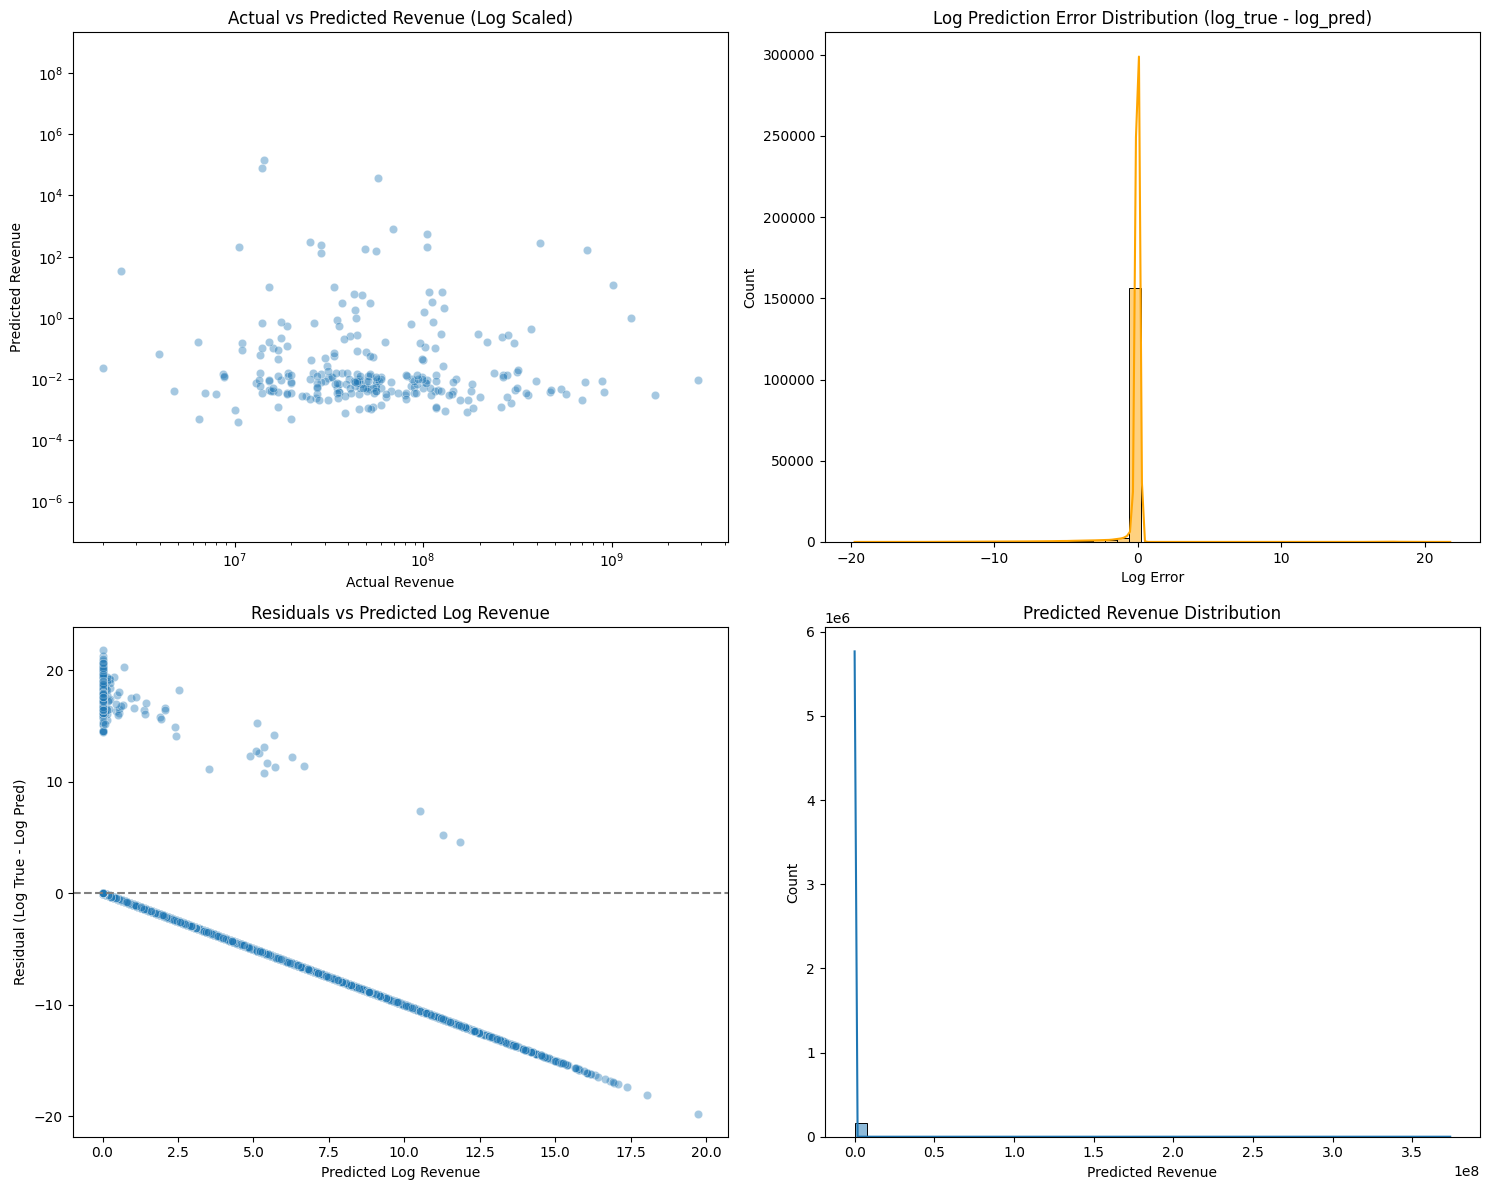

In [15]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

## 1. 실제 vs 예측 산점도
sns.scatterplot(data=val_pred_df, x='transactionRevenue', y='PredictedRevenue', ax=axes[0,0], alpha=0.4)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Actual vs Predicted Revenue (Log Scaled)')
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')

## 2. 로그 에러 분포
sns.histplot(val_pred_df["error"], bins=50, kde=True, ax=axes[0, 1], color="orange")
axes[0, 1].set_title("Log Prediction Error Distribution (log_true - log_pred)")
axes[0, 1].set_xlabel("Log Error")
axes[0, 1].set_ylabel("Count")

## 3. 잔차(residuals) vs 예측값
sns.scatterplot(x="log_pred", y="error", data=val_pred_df, ax=axes[1, 0], alpha=0.4)
axes[1, 0].axhline(0, linestyle="--", color="gray")
axes[1, 0].set_title("Residuals vs Predicted Log Revenue")
axes[1, 0].set_xlabel("Predicted Log Revenue")
axes[1, 0].set_ylabel("Residual (Log True - Log Pred)")

## 4. 예측값 분포
sns.histplot(val_pred_df["PredictedRevenue"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Predicted Revenue Distribution")
axes[1, 1].set_xlabel("Predicted Revenue")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### (4) feature importance

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_33535/944270475.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


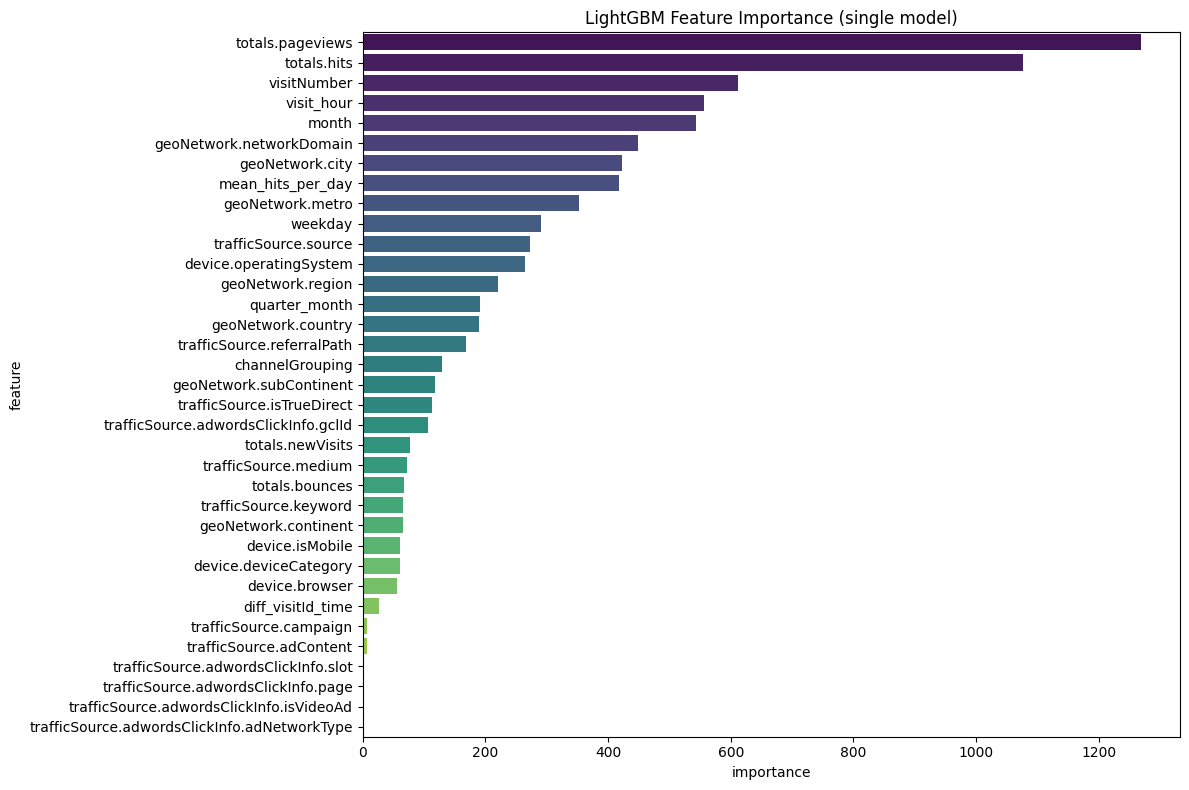

In [17]:
# feature importance 추출
feature_importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='split')
})

# 중요도 상위 N개 선택 (여기서는 전체 사용 가능)
cols = feature_importance_df.sort_values(by="importance", ascending=False)["feature"].values
best_features = feature_importance_df[feature_importance_df.feature.isin(cols)]

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    data=best_features.sort_values(by="importance", ascending=False),
    x="importance", y="feature", palette="viridis"
)
plt.title("LightGBM Feature Importance (single model)")
plt.tight_layout()
plt.show()